In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime

In [2]:
path = r'T:\DCProjects\Modeling\AADBT\data\Strava'

In [4]:
eug_cob = pd.read_csv(path+'\\EugCob_daily_2018-01-01-2021-12-31_ride\EugCob_Daily_Strava.csv')

In [6]:
spr = pd.read_csv(path+'\\Spr_daily_2018-01-01-2021-12-31_ride\Spr_Daily_Strava.csv')

In [77]:
data = eug_cob.append(spr, ignore_index=True)

In [78]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [79]:
data.date.isna().sum()

0

In [13]:
sp_data = gpd.read_file(r'T:\DCProjects\Modeling\AADBT\data\Predictors\Predictors.gdb',
                       layer='Daily_Strava_Merge')

In [15]:
sp_data.drop_duplicates(inplace=True, ignore_index=True)

In [17]:
sp_data.columns

Index(['edgeUID', 'osmId', 'Shape_Length', 'geometry'], dtype='object')

In [25]:
sp_data.rename(columns={"edgeUID": "edge_uid"}, inplace=True)

In [80]:
ndata = sp_data.merge(data[["edge_uid", "date", "total_trip_count"]], how="right", on="edge_uid")

In [81]:
ndata.date.isna().sum()

0

In [27]:
sp_data.shape

(66817, 4)

In [29]:
data.shape

(1361237, 39)

In [28]:
ndata.shape

(741579, 6)

In [71]:
ndata.head()

,edge_uid,osmId,Shape_Length,geometry,date,total_trip_count
0,314175236.0,945303804.0,0.011892,"MULTILINESTRING ((-13696785.920 5467610.143, -...",2019-08-13,10.0
1,314179447.0,436275350.0,0.000832,"MULTILINESTRING ((-13696562.554 5476419.498, -...",2019-08-13,5.0
2,314179447.0,436275350.0,0.000832,"MULTILINESTRING ((-13696562.554 5476419.498, -...",2020-04-21,5.0
3,314179447.0,436275350.0,0.000832,"MULTILINESTRING ((-13696562.554 5476419.498, -...",2020-04-16,5.0
4,314179447.0,436275350.0,0.000832,"MULTILINESTRING ((-13696562.554 5476419.498, -...",2018-08-02,5.0


In [32]:
outpath = r'T:\DCProjects\Modeling\AADBT\input'

In [33]:
bike_counts_loc = gpd.read_file(outpath + '\shp\BikeCountsLocations.shp')

In [82]:
ndata = ndata.to_crs(epsg=3857)

In [42]:
bike_counts_loc = bike_counts_loc.to_crs(epsg=3857)

In [83]:
bikecountloc_near_Strava = gpd.sjoin_nearest(bike_counts_loc, ndata, distance_col="distances", how="left")

In [84]:
bikecountloc_near_Strava.head()

,Location,geometry,index_right,edge_uid,osmId,Shape_Length,date,total_trip_count,distances
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),746781,314114855.0,958092094.0,0.003308,2021-06-09,5,1845.973735
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),746783,314114855.0,958092094.0,0.003308,2021-08-27,5,1845.973735
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),746782,314114855.0,958092094.0,0.003308,2020-06-06,5,1845.973735
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),746780,314114855.0,958092094.0,0.003308,2021-04-13,5,1845.973735
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),746779,314114855.0,958092094.0,0.003308,2021-02-20,5,1845.973735


In [85]:
bikecountloc_near_Strava.shape

(117092, 9)

In [86]:
bikecountloc_near_Strava.total_trip_count.isna().sum()

0

In [87]:
df = pd.read_csv(outpath+'\\Daily_Bike_Counts_With_AllVarData.csv')

In [88]:
df['Date'] = df.Date.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))

In [73]:
ndata.shape

(741579, 6)

In [89]:
ndata.date.isna().sum()

0

In [90]:
ndata['date'] = ndata.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [91]:
print(pd.date_range(
  start="2018-01-01", end="2021-12-31").difference(ndata.date))

DatetimeIndex(['2019-02-27', '2019-02-28'], dtype='datetime64[ns]', freq=None)


In [44]:
MPObd = gpd.read_file("X:/Data/Transportation/MPO_Bound.shp")

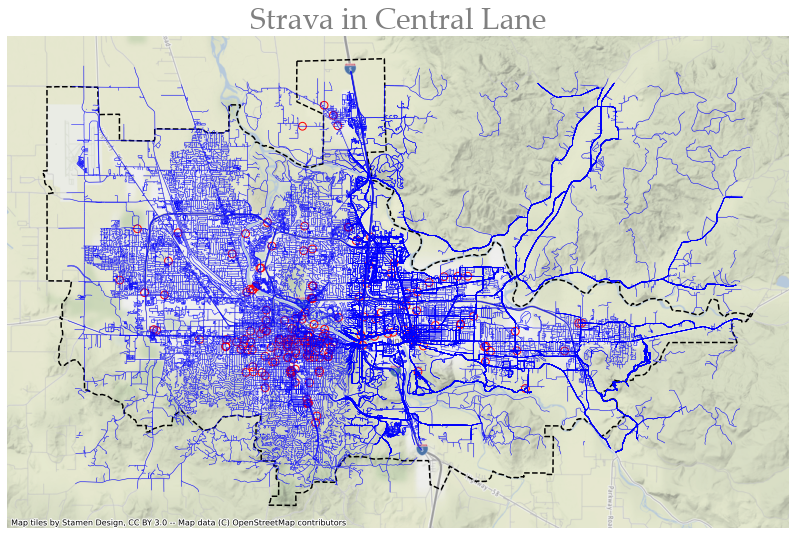

In [55]:
fig, ax = plt.subplots(figsize=(14, 12))
ndata.plot(ax=ax, color='blue', linewidth = 0.5, aspect=1)
bike_counts_loc.plot(ax=ax, marker ='o', facecolor="none", edgecolor="red", markersize=60, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Strava in Central Lane", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");